In [1]:
import re
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import time
path_root = '../anomaly_detection/'
sys.path.append(str(path_root))
from detectors import BlackBoxInfluenceFunctionDetector

In [2]:
dataset = "SMAP_MSL"
data_path = Path("../data/multivariate/") / dataset
test_df = pd.read_csv(data_path/"labeled_anomalies.csv")
smap_df = test_df.loc[test_df.spacecraft == "SMAP"]
df = smap_df.loc[smap_df.chan_id != "P-2"]

#### Univariate

In [3]:
class Config:
    def __init__(self):
        self.win_size = 25
        self.data_path = '../anomaly_detection/data_processed/SMAP'
        self.dimensions = [0]
        self.dataset = 'SMAP'
        self.verbose = False
        self.black_box_model = "LSTM"
        self.device = "cpu"
        self.lr = 1e-3
        self.num_epochs = 100
        self.weight_decay = 1e-4
        self.batch_size = 32
        self.n_layers = 1
        self.hidden_size = 16

df = smap_df.loc[smap_df.chan_id != "P-2"]
config = Config()
detector = BlackBoxInfluenceFunctionDetector(config)

anomaly ratio is 8.795 %.
start detection for channel P-1 ..
Block length: 25
Device:  cpu


/u/yzhang39/time-series-influence/demo/../anomaly_detection/detectors.py:326: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X).to(device), torch.tensor(Y).to(device)


Epoch 0: train RMSE 0.2168
Epoch 1: train RMSE 0.1982
Epoch 2: train RMSE 0.1941
Epoch 3: train RMSE 0.1915
Epoch 4: train RMSE 0.1899
Epoch 5: train RMSE 0.1884
Epoch 6: train RMSE 0.1873
Epoch 7: train RMSE 0.1866
Epoch 8: train RMSE 0.1851
Epoch 9: train RMSE 0.1840
Epoch 10: train RMSE 0.1833
Epoch 11: train RMSE 0.1825
Epoch 12: train RMSE 0.1816
Epoch 13: train RMSE 0.1810
Epoch 14: train RMSE 0.1810
Epoch 15: train RMSE 0.1804
Epoch 16: train RMSE 0.1800
Epoch 17: train RMSE 0.1800
Epoch 18: train RMSE 0.1797
Epoch 19: train RMSE 0.1795
Epoch 20: train RMSE 0.1794
Epoch 21: train RMSE 0.1793
Epoch 22: train RMSE 0.1796
Epoch 23: train RMSE 0.1791
Epoch 24: train RMSE 0.1787
Epoch 25: train RMSE 0.1794
Epoch 26: train RMSE 0.1786
Epoch 27: train RMSE 0.1785
Epoch 28: train RMSE 0.1783
Epoch 29: train RMSE 0.1783
Epoch 30: train RMSE 0.1780
Epoch 31: train RMSE 0.1780
Epoch 32: train RMSE 0.1780
Epoch 33: train RMSE 0.1778
Epoch 34: train RMSE 0.1775
Epoch 35: train RMSE 0.1776
Ep

Compute TimeInf: 100%|██████████| 8480/8480 [00:00<00:00, 31704.70it/s]


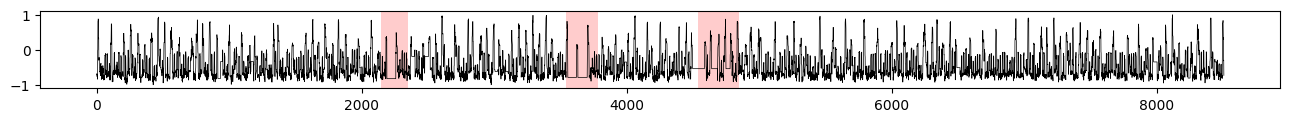

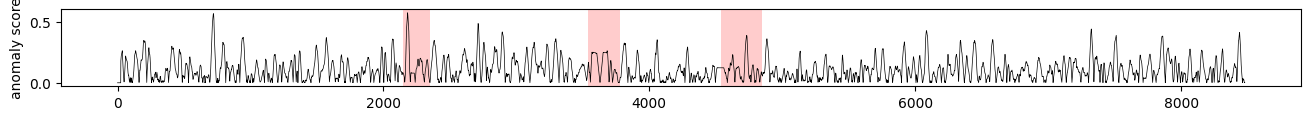

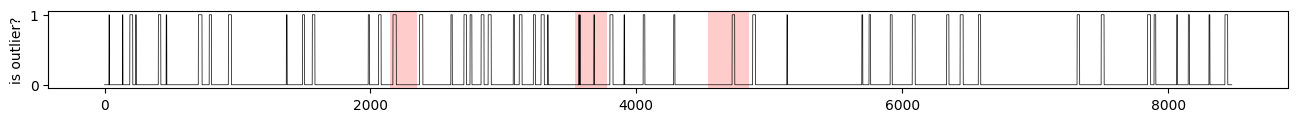

Threshold:0.25
Precision: 0.07 Recall: 0.07 F1: 0.07 AUC: 0.56


In [4]:
len_test_dict, len_anomaly_dict, len_ratio_dict = {}, {}, {}
prec_dict, rec_dict, f1_dict, auc_dict = {}, {}, {}, {}
time_dict = {}

for channel in df.chan_id:

    if config.dimensions is not None:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")[:,config.dimensions]
    else:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")

    seq_len = len(ts_test)
    anomaly_seqs = df.loc[df.chan_id == channel].anomaly_sequences.to_numpy().item()
    anomaly_seqs = re.findall(r'\d+', anomaly_seqs)
    anomaly_intervals = []
    for i in list(range(0, len(anomaly_seqs), 2)):
        anomaly_intervals.append(anomaly_seqs[i:i+2])
    anomaly_intervals = np.array(anomaly_intervals).astype(int)

    ground_truth = np.zeros(ts_test.shape[0])
    plt.figure(figsize=(16,1))
    plt.plot(ts_test, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.

    anomaly_len = sum(ground_truth)
    anomaly_ratio = anomaly_len / seq_len
    print(f"anomaly ratio is {anomaly_ratio * 100.:.3f} %.")

    len_test_dict.update({channel: seq_len})
    len_anomaly_dict.update({channel: anomaly_len})
    len_ratio_dict.update({channel: anomaly_ratio})

    print(f"start detection for channel {channel} ..")
    start_time = time.time()
    anomaly_scores = detector.calculate_anomaly_scores(ts = ts_test, channel_id = channel, contamination = min(anomaly_ratio,0.5)) # contamination has to be inthe range (0.0,0.5]
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)
    
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(anomaly_scores)] = anomaly_scores
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("anomaly score")
    plt.show()
    
    detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-anomaly_ratio) #
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(detected_outliers)] = detected_outliers
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("is outlier?")
    plt.show()
    
    prec, rec, f1, auc = detector.evaluate(ground_truth, anomaly_scores, anomaly_ratio)

    prec_dict.update({channel: prec})
    rec_dict.update({channel: rec})
    f1_dict.update({channel: f1})
    auc_dict.update({channel: auc})
    time_dict.update({channel: elapsed_time})

    break 

smap_metrics = pd.DataFrame({
    "Num_of_Test": len_test_dict,
    "Len_of_Anomaly": len_anomaly_dict,
    "Anomaly_Ratio": len_ratio_dict,
    "Precision": prec_dict,
    "Recall": rec_dict,
    "F1": f1_dict,
    "AUC": auc_dict,
    'Detection_Time(s)': time_dict
})

smap_metrics.insert(0, "Dataset", smap_metrics.index)
smap_metrics.reset_index(drop = True, inplace = True)